In [1]:
import numpy as np
from scipy import stats
from scipy import signal
import math
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import os
from os.path import sep
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from scipy.special import i0

In [2]:
from fly2p_function_TQ.imaging_2p_fixed_heading_period_analysis import find_stop_period_on_heading,PVA_during_stopPeriod,forwrad_speed_during_stopPeriod,bump_amplitude_during_stopPeriod,calculate_angle_difference_between_two_time_point, stopping_period_signal_decay,find_qualified_stopping_period
from fly2p_function_TQ.imaging_2p_fictrac_imaging_alignment import fictrack_signal_decoding
from fly2p_function_TQ.imaging_2p_PVA_functions import calcualteBumpAmplitude ,calcualteBumpAmplitude_V2_green, calcualteBumpAmplitude_V3, calculateBumpWidth_v1,von_Mises_fitting_dff_TQ, PVA_radian_to_angle,calcualteBumpAmplitude_V4

In [439]:
run_vonMises_fitting = 0
stable_PVA_threshold = 67.5
genotype = 'R55G08>sytGCaMP7f,'
celltype = 'delta7'
trial_condition = 'dark'

In [658]:
#Combine all persistence files for pooled analysis and statistics 

pooled_directory = ('/home/tianhaoqiu/Documents/GitHub/2p_analysis/preprocessing_output/normalized/delta7_PB/dark')
count = 0
output_df_pooled = pd.DataFrame()
#output_bump_amplitude_pooled = pd.DataFrame()
output_bump_amplitude_V2_pooled = pd.DataFrame()
output_bump_amplitude_V3_pooled = pd.DataFrame()
output_bump_amplitude_V3_opposite_pooled = pd.DataFrame()
output_bump_amplitude_V4_pooled = pd.DataFrame()
output_bump_width_pooled = pd.DataFrame()
output_PVA_strength_pooled = pd.DataFrame()
output_stable_PVA_index_pooled = []
if run_vonMises_fitting == 1:
    output_bump_amplitude_Vonmises_pooled = pd.DataFrame()
    output_bump_width_vonMises_pooled = pd.DataFrame()
    output_vonMises_gof_r2_pooled = pd.DataFrame()
for single_df in os.listdir(pooled_directory):
    current_file = pd.read_csv(sep.join([pooled_directory, single_df]))
    #Get time info
    volume_cycle = len(current_file )
    volume_time = current_file['Time_Stamp'][1]
    volume_rate = 1/volume_time
    time_array_imaging = np.arange(volume_cycle)/volume_rate
    #Get necessary parameters
    PVA_Unwrapped_Radian = current_file['Unwrapped_Radian']
    PVA_Angle = current_file['PVA_Angle']
    PVA_Radian = current_file['PVA_Radian']
    Angular_velocity = current_file['Angular_Velocity']
    integrated_x = current_file['Integrated_x']
    PVA_strength = current_file['PVA_strength']
    Bump_amplitude = current_file['Bump_amplitude']
    Unwrapped_heading = current_file['Unwrapped_Bar_Position/Heading']
    
    dff_normalized_8_roi = np.zeros((len(current_file['dFF_Roi_1']), 8))
    dff_normalized_8_roi_shifted = np.zeros((len(current_file['dFF_Roi_1']), 8))
    for i in range(len(current_file['F_Roi_1'])):
        dff_normalized_8_roi[i,0]= current_file['dFF_Roi_1'][i]
        dff_normalized_8_roi[i,1]= current_file['dFF_Roi_2'][i]
        dff_normalized_8_roi[i,2]= current_file['dFF_Roi_3'][i]
        dff_normalized_8_roi[i,3]= current_file['dFF_Roi_4'][i]
        dff_normalized_8_roi[i,4]= current_file['dFF_Roi_5'][i]
        dff_normalized_8_roi[i,5]= current_file['dFF_Roi_6'][i]
        dff_normalized_8_roi[i,6]= current_file['dFF_Roi_7'][i]
        dff_normalized_8_roi[i,7]= current_file['dFF_Roi_8'][i]
        dff_normalized_8_roi_shifted[i,0]= current_file['dFF_Roi_5'][i]
        dff_normalized_8_roi_shifted[i,1]= current_file['dFF_Roi_6'][i]
        dff_normalized_8_roi_shifted[i,2]= current_file['dFF_Roi_7'][i]
        dff_normalized_8_roi_shifted[i,3]= current_file['dFF_Roi_8'][i]
        dff_normalized_8_roi_shifted[i,4]= current_file['dFF_Roi_1'][i]
        dff_normalized_8_roi_shifted[i,5]= current_file['dFF_Roi_2'][i]
        dff_normalized_8_roi_shifted[i,6]= current_file['dFF_Roi_3'][i]
        dff_normalized_8_roi_shifted[i,7]= current_file['dFF_Roi_4'][i]
    dff_normalized_8_roi_shifted = dff_normalized_8_roi_shifted.transpose()
    #Need no series array for function below 
    PVA_Unwrapped_Radian_no_series = np.zeros(len(current_file['Unwrapped_Radian']))
    PVA_Angle_no_series = np.zeros(len(current_file['Unwrapped_Radian']))
    PVA_Radian_no_series = np.zeros(len(current_file['Unwrapped_Radian']))
    Angular_velocity_no_series = np.zeros(len(current_file['Unwrapped_Radian']))
    integrated_x_no_series = np.zeros(len(current_file['Unwrapped_Radian']))
    PVA_strength_no_series = np.zeros(len(current_file['Unwrapped_Radian']))
    Bump_amplitude_no_series = np.zeros(len(current_file['Unwrapped_Radian']))
    Unwrapped_heading_no_series = np.zeros(len(current_file['Unwrapped_Radian']))
    for i in range(len(current_file['Unwrapped_Radian'])):
        PVA_Unwrapped_Radian_no_series[i] = current_file['Unwrapped_Radian'][i]
        PVA_Angle[i] = current_file['PVA_Angle'][i]
        PVA_Angle_no_series[i] = current_file['PVA_Angle'][i]
        Angular_velocity_no_series[i] = current_file['Angular_Velocity'][i]
        integrated_x_no_series[i] = current_file['Integrated_x'][i]
        PVA_strength_no_series[i] = current_file['PVA_strength'][i]
        Bump_amplitude_no_series[i] = current_file['Bump_amplitude'][i]
        Unwrapped_heading_no_series[i] = current_file['Unwrapped_Bar_Position/Heading'][i]
        PVA_Radian_no_series[i] = current_file['PVA_Radian'][i]
    
    integrated_x_unwrapped =  fictrack_signal_decoding(integrated_x_no_series,time_array_imaging, 10, already_radian = True)
    Forward_velocity = np.gradient(integrated_x_unwrapped)/volume_time
    Forward_speed_radian = np.abs(Forward_velocity)
    Forward_speed_degrees =Forward_speed_radian * 180/np.pi
    
    #Get persistence period
    persistence_stop_index_and_length = find_stop_period_on_heading(head_velocity_array = Angular_velocity,degree_of_tolerance =15,shortest_stopFrame=int(np.ceil(3/volume_time)))
    
    #Calculate annd plot difference throughout the stop period
    difference_during_stop = []
    current_difference_during_stop = []
    current_forward_speed_during_stop = []
    forward_speed_during_stop =[]
    #plt.figure(figsize= (25,7))
    for current_index in range(len(persistence_stop_index_and_length)):
        current_stop_PVA = PVA_Angle_no_series[persistence_stop_index_and_length[current_index,0]-persistence_stop_index_and_length[current_index,1]+1]
        current_stop_start_index = persistence_stop_index_and_length[current_index,0]-persistence_stop_index_and_length[current_index,1]+1
        current_difference_during_stop = PVA_Angle_no_series[current_stop_start_index:persistence_stop_index_and_length[current_index,0]+1] - current_stop_PVA
        current_forward_speed_during_stop = Forward_speed_degrees[current_stop_start_index:persistence_stop_index_and_length[current_index,0]+1]
        #Modify the value so angle difference will never be different more than 180 degrees
        for j in range(len(current_difference_during_stop)):
            if np.abs(current_difference_during_stop[j]) > 180:
                if current_difference_during_stop[j] < 0:
                    current_difference_during_stop[j] =  current_difference_during_stop[j] + 360
                else:
                    current_difference_during_stop[j] =  current_difference_during_stop[j] - 360
        difference_during_stop.append(current_difference_during_stop)
        forward_speed_during_stop.append(current_forward_speed_during_stop)
    
    # A different way to calculate bump amplitude
    Bump_amplitude_V2 = calcualteBumpAmplitude_V2_green(dff_normalized_8_roi)
    
    # Another way to calculate bump amplitude by getting the normalized dff at current PVA angle 
    Bump_amplitude_V3, Bump_amplitude_V3_opposite = calcualteBumpAmplitude_V3(dff_normalized_8_roi,PVA_Radian_no_series)
    Bump_amplitude_V4 =  calcualteBumpAmplitude_V4(Bump_amplitude_V3,dff_normalized_8_roi,PVA_Radian_no_series,persistence_stop_index_and_length)
    
    # Bump_width
    Bump_width = calculateBumpWidth_v1(dff_normalized_8_roi, 8)
    
    
    
    if run_vonMises_fitting == 1:
        #Vonmises fitting way for bump amplitude/width and gof
        def vonMises_function_TQ(x, k, m, c):
            return (np.exp(k * np.cos(x-m))) + c
        x_vm_fitting = np.array([-np.pi*7/8,-np.pi*5/8,-np.pi*3/8,-np.pi/8,np.pi/8,np.pi*3/8,np.pi*5/8,np.pi*7/8])
        vm_parameters,vonMises_value_array,vonMises_gof_r2 = von_Mises_fitting_dff_TQ(function = vonMises_function_TQ, x_data = x_vm_fitting,y_data = dff_normalized_8_roi_shifted)
        bump_amplitude_vonMises = np.zeros((len(vonMises_value_array)))
        bump_width_vonMises = np.zeros((len(vonMises_value_array)))
        for i in range(len(vonMises_value_array)):
            bump_amplitude_vonMises[i] = np.exp(vm_parameters[i,0]) - np.exp(-vm_parameters[i,0])
            bump_width_vonMises[i] = 2*np.abs(np.arccos((1/vm_parameters[i,0])*np.log(0.5*(np.exp(vm_parameters[i,0])+np.exp(-vm_parameters[i,0]))))) 
        bump_width_vonMises = PVA_radian_to_angle(bump_width_vonMises)
    
    bump_amplitude_stopping_duration = 20
    minimum_frame_length = int(np.ceil(bump_amplitude_stopping_duration/volume_time))
    #200ms bin size
    bump_amplitude_stopping_bin_size = 0.2
    
    #gaussian smooth the Bump Amplitude/PVA Strength Array as in Fisher, Marquis 2022
    #Bump_amplitude_gaussian_smooth = gaussian_filter1d(Bump_amplitude, sigma =3)
    Bump_amplitude_gaussian_smooth = Bump_amplitude
    PVA_strength_gaussian_smooth = gaussian_filter1d(PVA_strength, sigma =3)
    #Bump_amplitude_v2_gaussian_smooth = gaussian_filter1d(Bump_amplitude_V2, sigma =3)
    Bump_amplitude_v2_gaussian_smooth = Bump_amplitude_V2
    Bump_width_gaussian_smooth = gaussian_filter1d(Bump_width, sigma =3)
    
    
    #Get qualified stopping period for decay analysis 
    qualified_stopping_index_and_length, qualified_stable_PVA_index = find_qualified_stopping_period (volume_time =volume_time,stopping_array=persistence_stop_index_and_length,PVAinAngle=PVA_Angle_no_series,minimum_frame_length=int(np.ceil(bump_amplitude_stopping_duration/volume_time)),stable_PVA_threshold=stable_PVA_threshold)
    active_period_before_len =1
    
    
    stopping_period_PVA_strength_current = stopping_period_signal_decay(volume_time, bump_amplitude_stopping_duration,bump_amplitude_stopping_bin_size = 0.2, signal_array =PVA_strength_gaussian_smooth, qualified_stop_array=qualified_stopping_index_and_length,active_period_before_len=active_period_before_len)
    #bump_amplitude_stopping_current = stopping_period_signal_decay(volume_time, bump_amplitude_stopping_duration,bump_amplitude_stopping_bin_size = 0.2, signal_array =Bump_amplitude_gaussian_smooth, qualified_stop_array=qualified_stopping_index_and_length,active_period_before_len=active_period_before_len)
    bump_amplitude_v2_stopping_current = stopping_period_signal_decay(volume_time, bump_amplitude_stopping_duration,bump_amplitude_stopping_bin_size = 0.2, signal_array =Bump_amplitude_v2_gaussian_smooth, qualified_stop_array=qualified_stopping_index_and_length,active_period_before_len=active_period_before_len)
    bump_amplitude_v3_stopping_current = stopping_period_signal_decay(volume_time, bump_amplitude_stopping_duration,bump_amplitude_stopping_bin_size = 0.2, signal_array =Bump_amplitude_V3, qualified_stop_array=qualified_stopping_index_and_length,active_period_before_len=active_period_before_len)
    bump_amplitude_v3_opposite_stopping_current = stopping_period_signal_decay(volume_time, bump_amplitude_stopping_duration,bump_amplitude_stopping_bin_size = 0.2, signal_array =Bump_amplitude_V3_opposite, qualified_stop_array=qualified_stopping_index_and_length,active_period_before_len=active_period_before_len)
    bump_amplitude_v4_stopping_current = stopping_period_signal_decay(volume_time, bump_amplitude_stopping_duration,bump_amplitude_stopping_bin_size = 0.2, signal_array =Bump_amplitude_V4, qualified_stop_array=qualified_stopping_index_and_length,active_period_before_len=active_period_before_len)
    bump_width_stopping_current = stopping_period_signal_decay(volume_time, bump_amplitude_stopping_duration,bump_amplitude_stopping_bin_size = 0.2, signal_array =Bump_width_gaussian_smooth, qualified_stop_array=qualified_stopping_index_and_length,active_period_before_len=active_period_before_len)
    if run_vonMises_fitting == 1:
        bump_amplitude_vonMises_stopping_current = stopping_period_signal_decay(volume_time, bump_amplitude_stopping_duration,bump_amplitude_stopping_bin_size = 0.2, signal_array =Bump_amplitude_vonMises_smooth, qualified_stop_array=qualified_stopping_index_and_length,active_period_before_len=active_period_before_len)
        bump_width_vonMises_stopping_current = stopping_period_signal_decay(volume_time, bump_amplitude_stopping_duration,bump_amplitude_stopping_bin_size = 0.2, signal_array =Bump_width_vonMises_smooth, qualified_stop_array=qualified_stopping_index_and_length,active_period_before_len=active_period_before_len)
        VonMises_gof_r2_stopping_current = stopping_period_signal_decay(volume_time, bump_amplitude_stopping_duration,bump_amplitude_stopping_bin_size = 0.2, signal_array =VonMises_gof_r2_smooth, qualified_stop_array=qualified_stopping_index_and_lengthl,active_period_before_len=active_period_before_len)
    
    
    #stopping_period_bump_amp_current = pd.DataFrame(bump_amplitude_stopping_current.transpose())
    stopping_period_bump_amp_v2_current = pd.DataFrame(bump_amplitude_v2_stopping_current.transpose())
    stopping_period_bump_amp_v3_current = pd.DataFrame(bump_amplitude_v3_stopping_current.transpose())
    stopping_period_bump_amp_v3_opposite_current = pd.DataFrame(bump_amplitude_v3_opposite_stopping_current.transpose())
    stopping_period_bump_amp_v4_current = pd.DataFrame(bump_amplitude_v4_stopping_current.transpose())
    stopping_period_bump_width_current = pd.DataFrame(bump_width_stopping_current.transpose())
    stopping_period_PVA_strength_current = pd.DataFrame(stopping_period_PVA_strength_current.transpose())
    if run_vonMises_fitting == 1:
        stopping_bump_amplitude_vonMises_current = pd.DataFrame(bump_amplitude_vonMises_stopping_current.transpose())
        stopping_period_bump_width_vonMises_current = pd.DataFrame(bump_width_vonMises_stopping_current.transpose())
        stopping_period_VonMises_gof_r2_current = pd.DataFrame(VonMises_gof_r2_stopping_current.transpose())
    
    
    
    if count == 0:
        #output_bump_amplitude_pooled = stopping_period_bump_amp_current
        output_PVA_strength_pooled =  stopping_period_PVA_strength_current
        output_bump_amplitude_V2_pooled = stopping_period_bump_amp_v2_current
        output_bump_amplitude_V3_pooled = stopping_period_bump_amp_v3_current
        output_bump_amplitude_V3_opposite_pooled = stopping_period_bump_amp_v3_opposite_current
        output_bump_amplitude_V4_pooled = stopping_period_bump_amp_v4_current
        output_bump_width_pooled = stopping_period_bump_width_current
        if run_vonMises_fitting == 1:
            output_bump_amplitude_Vonmises_pooled = stopping_bump_amplitude_vonMises_current
            output_bump_width_vonMises_pooled = stopping_period_bump_width_vonMises_current
            output_vonMises_gof_r2_pooled = stopping_period_VonMises_gof_r2_current
    else:
        #output_bump_amplitude_pooled = pd.concat([output_bump_amplitude_pooled,stopping_period_bump_amp_current],ignore_index=True, axis =1)
        output_PVA_strength_pooled = pd.concat([output_PVA_strength_pooled,stopping_period_PVA_strength_current],ignore_index=True, axis =1)
        output_bump_amplitude_V2_pooled = pd.concat([output_bump_amplitude_V2_pooled,stopping_period_bump_amp_v2_current],ignore_index=True, axis =1)
        output_bump_amplitude_V3_pooled = pd.concat([output_bump_amplitude_V3_pooled,stopping_period_bump_amp_v3_current],ignore_index=True, axis =1)
        output_bump_amplitude_V3_opposite_pooled = pd.concat([output_bump_amplitude_V3_opposite_pooled,stopping_period_bump_amp_v3_opposite_current],ignore_index=True, axis =1)
        output_bump_amplitude_V4_pooled = pd.concat([output_bump_amplitude_V4_pooled,stopping_period_bump_amp_v4_current],ignore_index=True, axis =1)
        output_bump_width_pooled = pd.concat([output_bump_width_pooled,stopping_period_bump_width_current],ignore_index=True, axis =1)        
        if run_vonMises_fitting == 1:
            output_bump_amplitude_Vonmises_pooled = pd.concat([output_bump_amplitude_Vonmises_pooled, stopping_bump_amplitude_vonMises_current],ignore_index=True, axis =1)
            output_bump_width_vonMises_pooled = pd.concat([output_bump_width_vonMises_pooled, stopping_period_bump_width_vonMises_current],ignore_index=True, axis =1)
            output_vonMises_gof_r2_pooled = pd.concat([output_vonMises_gof_r2_pooled, stopping_period_VonMises_gof_r2_current],ignore_index=True, axis =1)
    
    for i in range(len(qualified_stable_PVA_index)):
        output_stable_PVA_index_pooled.append(int(qualified_stable_PVA_index[i]))
    
    PVA_angle_at_stop = PVA_during_stopPeriod(stop_index_array = persistence_stop_index_and_length, PVA_array =PVA_Angle_no_series, volume_time=volume_time)
    single_trial_info = single_df.split("-")
    flytrial = [single_trial_info[0], single_trial_info[1]]
    PVA_angle_at_stop.insert(0,'FlyTrial',"-".join(flytrial))
    PVA_angle_at_stop.insert(1,'Genotype',genotype)
    PVA_angle_at_stop.insert(2,'TrialType',trial_condition)
    Forward_speed_at_stop = forwrad_speed_during_stopPeriod(stop_index_array=persistence_stop_index_and_length,forward_speed_array=Forward_speed_degrees, volume_time=volume_time)
    Bump_amplitude_at_stop = bump_amplitude_during_stopPeriod(stop_index_array=persistence_stop_index_and_length,bump_amplitude_array=Bump_amplitude_no_series, volume_time=volume_time)
    output_df = pd.concat([PVA_angle_at_stop,Forward_speed_at_stop,Bump_amplitude_at_stop], axis=1)
    
    if count == 0:
        output_df_pooled = output_df
    else:
        output_df_pooled = pd.concat([output_df_pooled,output_df], ignore_index=True)
    
    count = count + 1

In [659]:
output_bump_amplitude_V3_pooled.shape

(105, 39)

In [660]:
from scipy.interpolate import UnivariateSpline

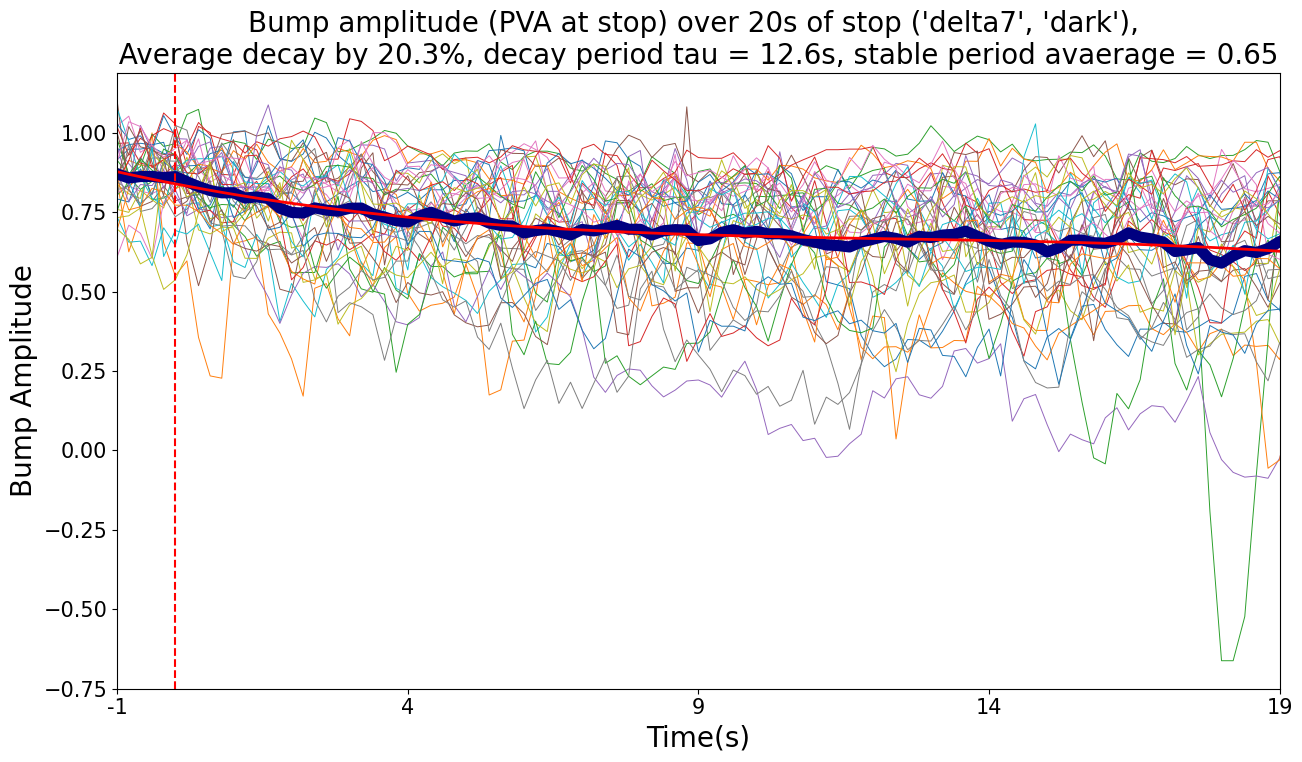

In [661]:
average_decay_Bump_a_V4 = round((output_bump_amplitude_V4_pooled.mean(axis=1)[0]-output_bump_amplitude_V4_pooled.mean(axis=1)[49])/output_bump_amplitude_V4_pooled.mean(axis=1)[0]*100,2)
time_array_decay = np.arange(len(output_bump_amplitude_V4_pooled.mean(axis=1)))/5
plt.figure(figsize=(15,8))
for i in range(len(output_bump_amplitude_V4_pooled.columns)):
    plt.plot(time_array_decay,output_bump_amplitude_V4_pooled[i],linewidth = 0.7)
plt.plot(time_array_decay,output_bump_amplitude_V4_pooled.mean(axis=1), linewidth=8, color = 'navy')
spl_V4 = UnivariateSpline(time_array_decay,output_bump_amplitude_V4_pooled.mean(axis=1),k=3, s=3)
plt.plot(time_array_decay,spl_V4(time_array_decay),linewidth=2, color ='red')
plt.xticks(ticks=plt.xticks()[0][0:], labels=np.array(plt.xticks()[0][0:]-active_period_before_len, dtype=np.int64), fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(0,bump_amplitude_stopping_duration)
plt.axvline(x= 1, color = 'r',linestyle ='--')
plt.xlabel('Time(s)', fontsize=20)
plt.ylabel('Bump Amplitude', fontsize=20)

cutpoint_v4 =np.absolute(np.gradient(spl_V4(t))-0).argmin()
mean_v4 = output_bump_amplitude_V4_pooled.mean(axis=1)
tau_v4 = np.around(np.absolute(mean_v4[0:cutpoint_v4]-mean_v4[0]*0.632).argmin()*0.2, decimals=2)
stable_mean_v4 = np.around(np.mean(mean_v4[cutpoint_v4:]),decimals=2)
plt.title(f"Bump amplitude (PVA at stop) over {bump_amplitude_stopping_duration}s of stop {celltype, trial_condition}, \n Average decay by {average_decay_Bump_a_V4}%, decay period tau = {tau_v4}s, stable period avaerage = {stable_mean_v4} ",fontsize =20)
plt.show()


In [662]:
time_array_decay[100:105]

array([20. , 20.2, 20.4, 20.6, 20.8])

In [663]:
spl_V3.get_knots()

array([ 0. , 20.8])

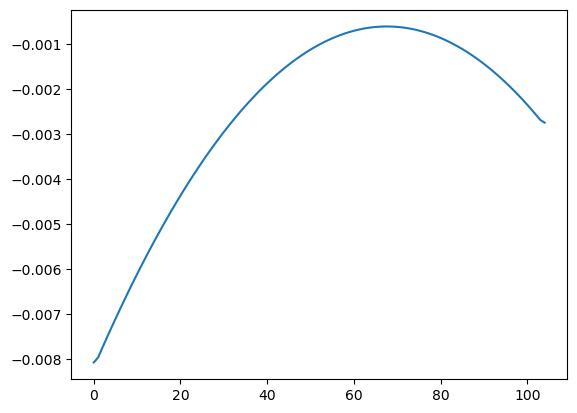

In [664]:
plt.plot(np.gradient(spl_V4(time_array_decay)))

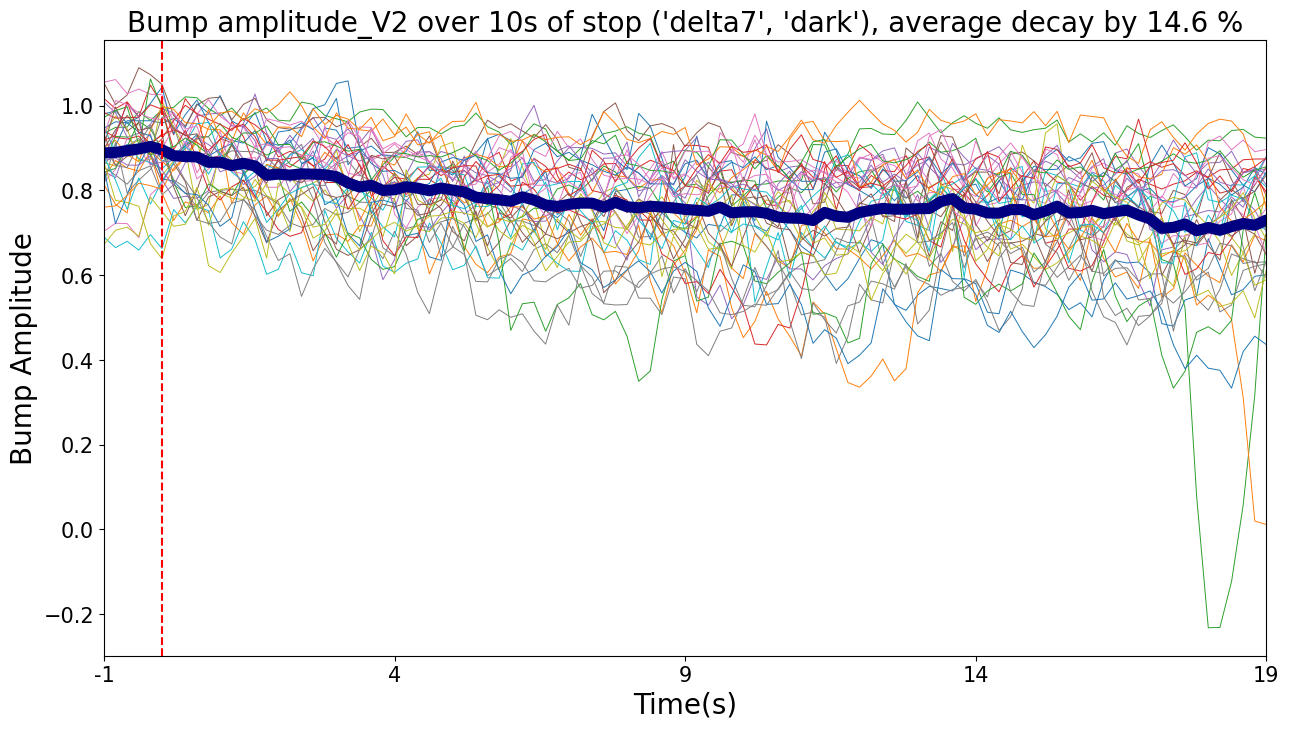

In [665]:
average_decay_Bump_a_V2 = round((output_bump_amplitude_V2_pooled.mean(axis=1)[0]-output_bump_amplitude_V2_pooled.mean(axis=1)[49])/output_bump_amplitude_V2_pooled.mean(axis=1)[0]*100,2)
time_array_decay = np.arange(len(output_bump_amplitude_V2_pooled.mean(axis=1)))/5
plt.figure(figsize=(15,8))
for i in range(len(output_bump_amplitude_V2_pooled.columns)):
    plt.plot(time_array_decay,output_bump_amplitude_V2_pooled[i],linewidth = 0.7)
plt.plot(time_array_decay,output_bump_amplitude_V2_pooled.mean(axis=1), linewidth=8, color = 'navy')
plt.xticks(ticks=plt.xticks()[0][0:], labels=np.array(plt.xticks()[0][0:]-active_period_before_len, dtype=np.int64), fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(0,bump_amplitude_stopping_duration)
plt.axvline(x= 1, color = 'r',linestyle ='--')
plt.xlabel('Time(s)', fontsize=20)
plt.ylabel('Bump Amplitude', fontsize=20)
plt.title(f"Bump amplitude_V2 over 10s of stop {celltype, trial_condition}, average decay by {average_decay_Bump_a_V2} %",fontsize =20)
plt.show()

In [666]:
Bump_amp_V3_stable = pd.DataFrame()
Bump_amp_V3_unstable = pd.DataFrame()
Bump_amp_V3_opposite_stable = pd.DataFrame()
Bump_amp_V3_opposite_unstable = pd.DataFrame()
for i in range(len(output_stable_PVA_index_pooled)):
    if output_stable_PVA_index_pooled[i] == 0:
        if i == 0:
            Bump_amp_V3_unstable = output_bump_amplitude_V3_pooled[i]
            Bump_amp_V3_opposite_unstable = output_bump_amplitude_V3_opposite_pooled[i]
        else:
            Bump_amp_V3_unstable = pd.concat([Bump_amp_V3_unstable,output_bump_amplitude_V3_pooled[i]],ignore_index=True, axis =1)
            Bump_amp_V3_opposite_unstable = pd.concat([Bump_amp_V3_opposite_unstable,output_bump_amplitude_V3_opposite_pooled[i]],ignore_index=True, axis =1)
    else:
        if i == 0:
            Bump_amp_V3_stable = output_bump_amplitude_V3_pooled[i]
            Bump_amp_V3_opposite_stable = output_bump_amplitude_V3_opposite_pooled[i]
        else:
            Bump_amp_V3_stable = pd.concat([Bump_amp_V3_stable,output_bump_amplitude_V3_pooled[i]],ignore_index=True, axis =1)
            Bump_amp_V3_opposite_stable = pd.concat([Bump_amp_V3_opposite_stable,output_bump_amplitude_V3_opposite_pooled[i]],ignore_index=True, axis =1)

In [667]:
Bump_amp_V3_stable.shape

(105, 31)

In [668]:
Bump_amp_V3_unstable.shape

(105, 8)

In [669]:
Bump_amp_V3_stable.mean(axis=1)[50]

0.6846481434179437

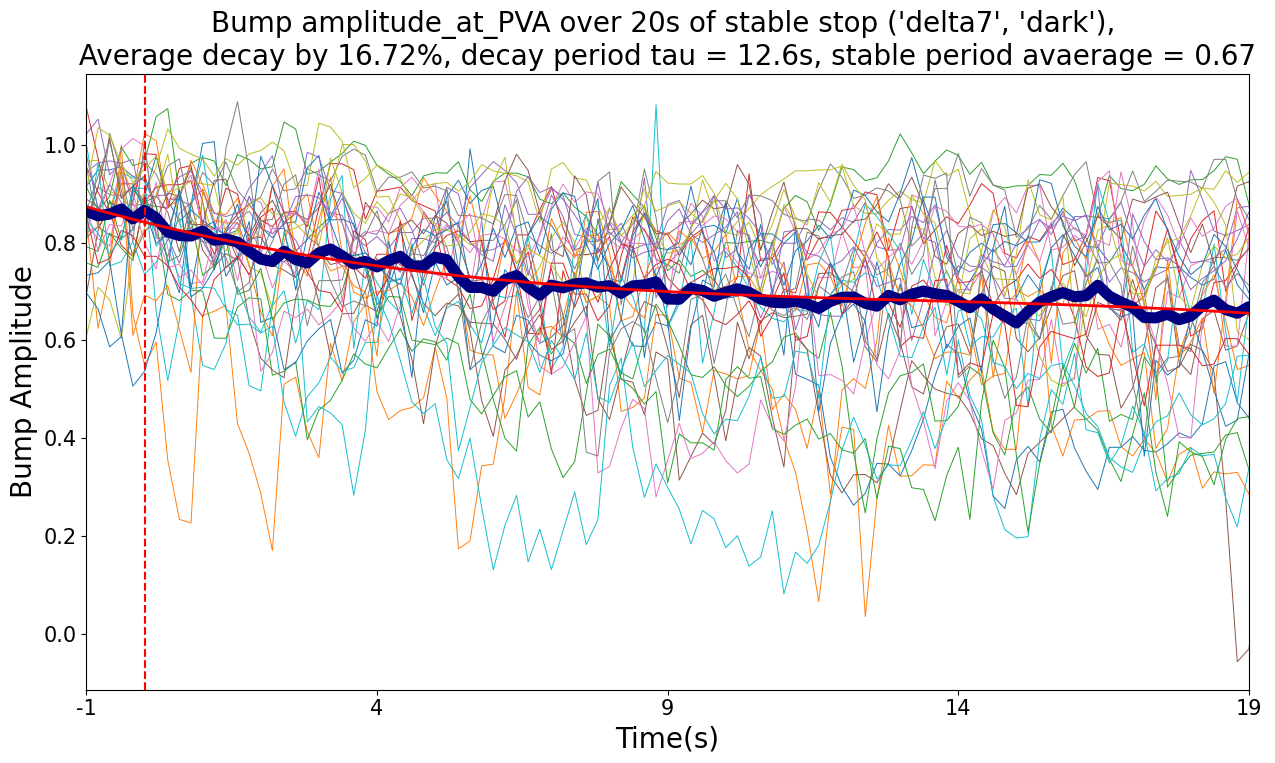

In [670]:
average_decay_stable_Bump_a_V3 = round((Bump_amp_V3_stable.mean(axis=1)[0]-Bump_amp_V3_stable.mean(axis=1)[49])/Bump_amp_V3_stable.mean(axis=1)[0]*100,2)
time_array_decay = np.arange(len(Bump_amp_V3_stable.mean(axis=1)))/5
plt.figure(figsize=(15,8))
for i in range(len(Bump_amp_V3_stable.columns)):
    plt.plot(time_array_decay,Bump_amp_V3_stable[i],linewidth = 0.7)
plt.plot(time_array_decay,Bump_amp_V3_stable.mean(axis=1), linewidth=8, color = 'navy')
spl_V3 = UnivariateSpline(time_array_decay,Bump_amp_V3_stable.mean(axis=1),k=3, s=3)
plt.plot(time_array_decay,spl_V3(time_array_decay),linewidth=2, color ='red')
plt.xticks(ticks=plt.xticks()[0][0:], labels=np.array(plt.xticks()[0][0:]-active_period_before_len, dtype=np.int64), fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(0,bump_amplitude_stopping_duration)
plt.axvline(x= 1, color = 'r',linestyle ='--')
plt.xlabel('Time(s)', fontsize=20)
plt.ylabel('Bump Amplitude', fontsize=20)


cutpoint_v3 =np.absolute(np.gradient(spl_V3(t))-0).argmin()
mean_v3 = Bump_amp_V3_stable.mean(axis=1)
tau_v3 = np.around(np.absolute(mean_v3[0:cutpoint_v3]-mean_v3[0]*0.632).argmin()*0.2, decimals=2)
stable_mean_v3 = np.around(np.mean(mean_v3[cutpoint_v3:]),decimals=2)

#plt.title(f"Bump amplitude_at_PVA over 10s of stable stop {celltype, trial_condition}, average decay by {average_decay_stable_Bump_a_V3} %",fontsize =20)
plt.title(f"Bump amplitude_at_PVA over {bump_amplitude_stopping_duration}s of stable stop {celltype, trial_condition}, \n Average decay by {average_decay_stable_Bump_a_V3}%, decay period tau = {tau_v3}s, stable period avaerage = {stable_mean_v3} ",fontsize =20)
plt.show()

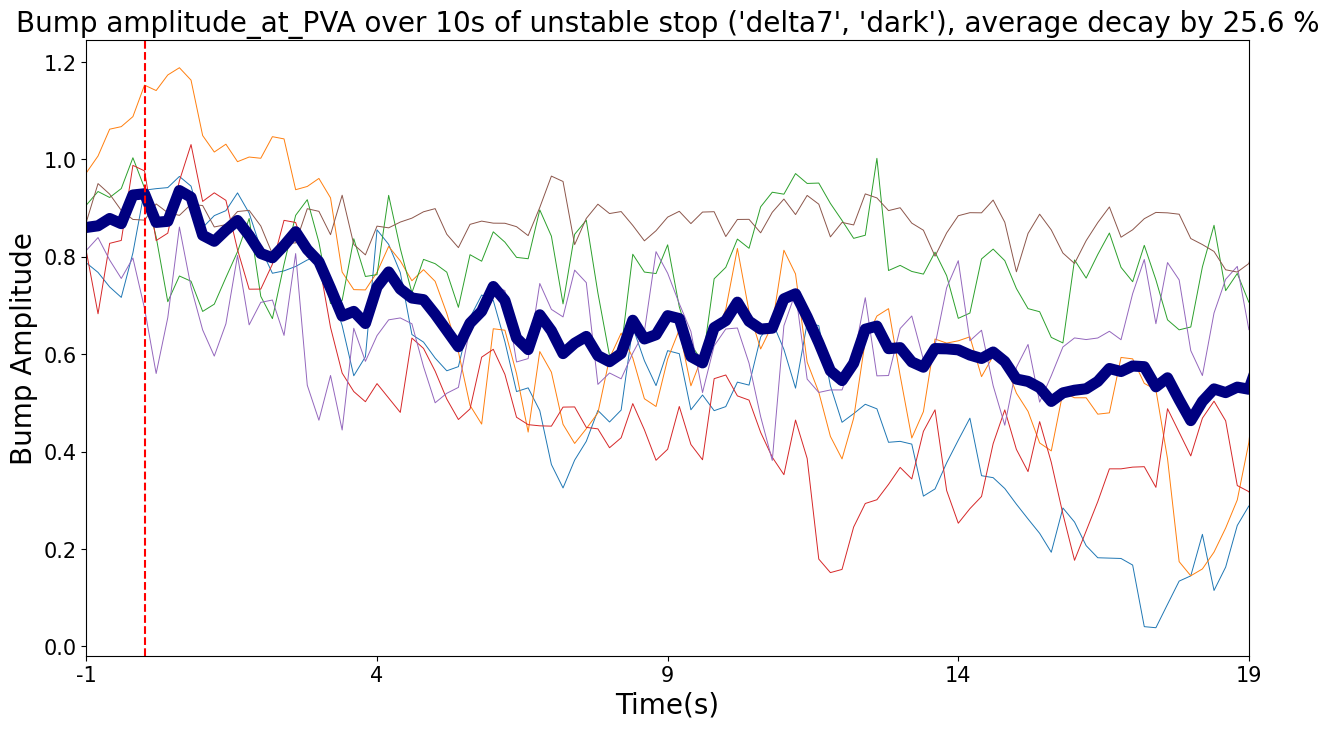

In [657]:
average_decay_unstable_Bump_a_V3 = round((Bump_amp_V3_unstable.mean(axis=1)[0]-Bump_amp_V3_unstable.mean(axis=1)[49])/Bump_amp_V3_unstable.mean(axis=1)[0]*100,2)
time_array_decay = np.arange(len(Bump_amp_V3_unstable.mean(axis=1)))/5
plt.figure(figsize=(15,8))
for i in range(len(Bump_amp_V3_unstable.columns)):
    plt.plot(time_array_decay,Bump_amp_V3_unstable[i],linewidth = 0.7)
plt.plot(time_array_decay,Bump_amp_V3_unstable.mean(axis=1), linewidth=8, color = 'navy')
plt.xticks(ticks=plt.xticks()[0][0:], labels=np.array(plt.xticks()[0][0:]-active_period_before_len, dtype=np.int64), fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(0,bump_amplitude_stopping_duration)
plt.axvline(x= 1, color = 'r',linestyle ='--')
plt.xlabel('Time(s)', fontsize=20)
plt.ylabel('Bump Amplitude', fontsize=20)
plt.title(f"Bump amplitude_at_PVA over 10s of unstable stop {celltype, trial_condition}, average decay by {average_decay_unstable_Bump_a_V3} %",fontsize =20)
plt.show()

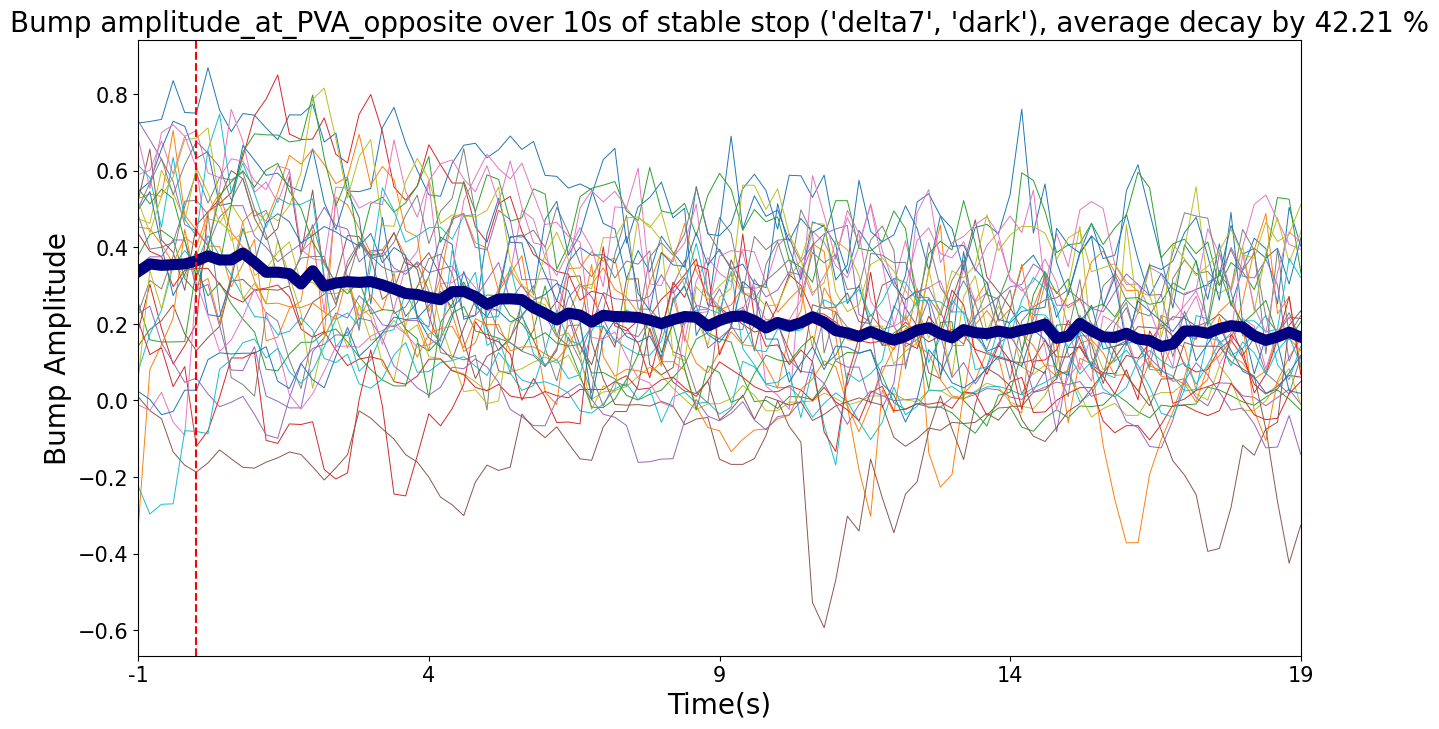

In [642]:
average_decay_stable_Bump_a_opposite_V3 = round((Bump_amp_V3_opposite_stable.mean(axis=1)[0]-Bump_amp_V3_opposite_stable.mean(axis=1)[49])/Bump_amp_V3_opposite_stable.mean(axis=1)[0]*100,2)
time_array_decay = np.arange(len(Bump_amp_V3_stable.mean(axis=1)))/5
plt.figure(figsize=(15,8))
for i in range(len(Bump_amp_V3_opposite_stable.columns)):
    plt.plot(time_array_decay,Bump_amp_V3_opposite_stable[i],linewidth = 0.7)
plt.plot(time_array_decay,Bump_amp_V3_opposite_stable.mean(axis=1), linewidth=8, color = 'navy')
plt.xticks(ticks=plt.xticks()[0][0:], labels=np.array(plt.xticks()[0][0:]-active_period_before_len, dtype=np.int64), fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(0,bump_amplitude_stopping_duration)
plt.axvline(x= 1, color = 'r',linestyle ='--')
plt.xlabel('Time(s)', fontsize=20)
plt.ylabel('Bump Amplitude', fontsize=20)
plt.title(f"Bump amplitude_at_PVA_opposite over 10s of stable stop {celltype, trial_condition}, average decay by {average_decay_stable_Bump_a_opposite_V3} %",fontsize =20)
plt.show()

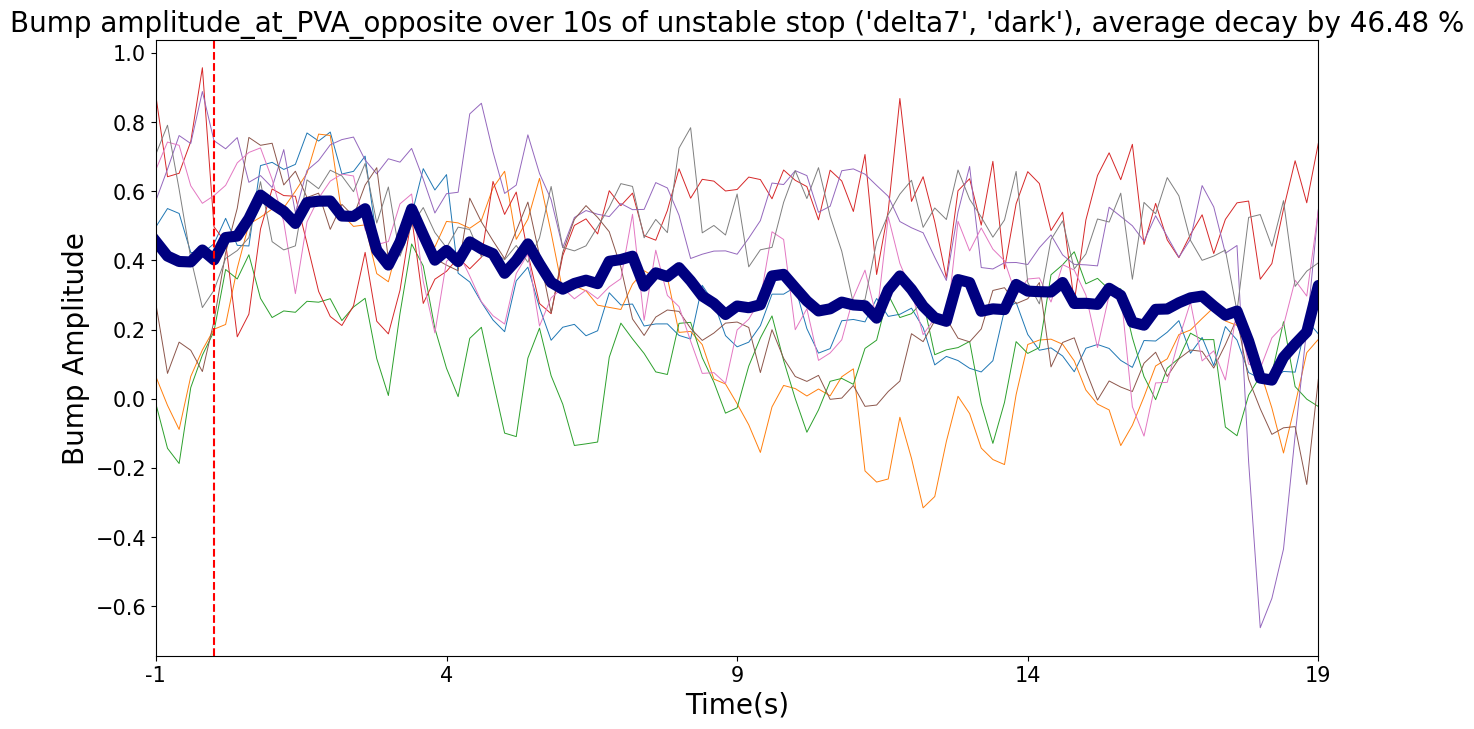

In [643]:
average_decay_unstable_Bump_a_opposite_V3 = round((Bump_amp_V3_opposite_unstable.mean(axis=1)[0]-Bump_amp_V3_opposite_unstable.mean(axis=1)[49])/Bump_amp_V3_opposite_unstable.mean(axis=1)[0]*100,2)
time_array_decay = np.arange(len(Bump_amp_V3_stable.mean(axis=1)))/5
plt.figure(figsize=(15,8))
for i in range(len(Bump_amp_V3_opposite_unstable.columns)):
    plt.plot(time_array_decay,Bump_amp_V3_opposite_unstable[i],linewidth = 0.7)
plt.plot(time_array_decay,Bump_amp_V3_opposite_unstable.mean(axis=1), linewidth=8, color = 'navy')
plt.xticks(ticks=plt.xticks()[0][0:], labels=np.array(plt.xticks()[0][0:]-active_period_before_len, dtype=np.int64), fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(0,bump_amplitude_stopping_duration)
plt.axvline(x= 1, color = 'r',linestyle ='--')
plt.xlabel('Time(s)', fontsize=20)
plt.ylabel('Bump Amplitude', fontsize=20)
plt.title(f"Bump amplitude_at_PVA_opposite over 10s of unstable stop {celltype, trial_condition}, average decay by {average_decay_unstable_Bump_a_opposite_V3} %",fontsize =20)
plt.show()

In [626]:
if run_vonMises_fitting == 1:
    average_decay_Bump_v = round((output_bump_amplitude_Vonmises_pooled.mean(axis=1)[0]-output_bump_amplitude_Vonmises_pooled.mean(axis=1)[49])/output_bump_amplitude_Vonmises_pooled.mean(axis=1)[0]*100,2)
    time_array_decay = np.arange(len(output_bump_amplitude_Vonmises_pooled.mean(axis=1)))/5
    plt.figure(figsize=(10,6))
    for i in range(len(output_bump_amplitude_Vonmises_pooled.columns)):
        plt.plot(time_array_decay,output_bump_amplitude_Vonmises_pooled[i],linewidth = 0.7)
    plt.plot(time_array_decay,output_bump_amplitude_Vonmises_pooled.mean(axis=1), linewidth=8, color = 'navy')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlim(0,9.8)
    plt.xlabel('Time(s)', fontsize=20)
    plt.ylabel('Bump Amplitude-von mises', fontsize=20)
    plt.title(f"Bump amplitude over 10s of stop {celltype, trial_condition}, average decay by {average_decay_Bump_v} %",fontsize =20)
    plt.show()

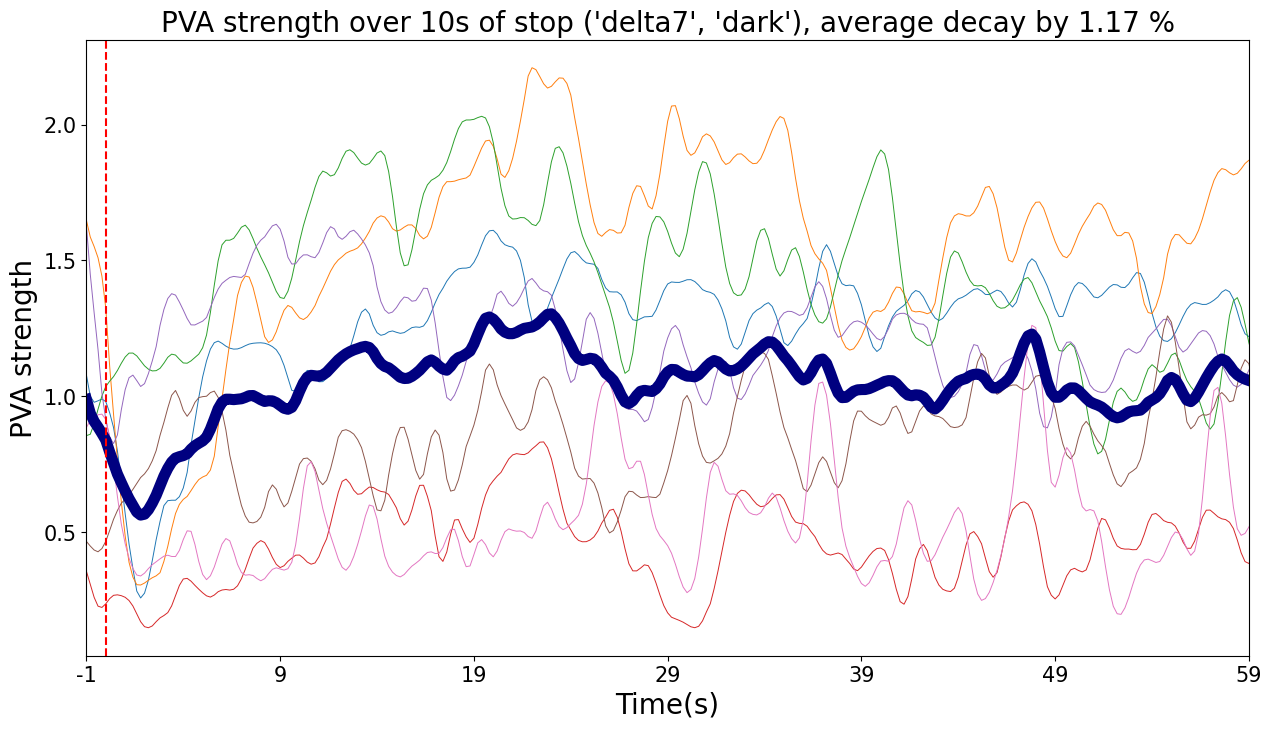

In [627]:
average_decay_PVA_S = round((output_PVA_strength_pooled.mean(axis=1)[0]-output_PVA_strength_pooled.mean(axis=1)[49])/output_PVA_strength_pooled.mean(axis=1)[0]*100,2)
time_array_decay = np.arange(len(output_PVA_strength_pooled.mean(axis=1)))/5
plt.figure(figsize=(15,8))
for i in range(len(output_PVA_strength_pooled.columns)):
    plt.plot(time_array_decay,output_PVA_strength_pooled[i], linewidth = 0.7)
plt.plot(time_array_decay,output_PVA_strength_pooled.mean(axis=1), linewidth=8, color = 'navy')
plt.xticks(ticks=plt.xticks()[0][0:], labels=np.array(plt.xticks()[0][0:]-active_period_before_len, dtype=np.int64), fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(0,bump_amplitude_stopping_duration)
plt.axvline(x= 1, color = 'r',linestyle ='--')
plt.xlabel('Time(s)', fontsize=20)
plt.ylabel('PVA strength', fontsize=20)
plt.title(f"PVA strength over 10s of stop {celltype, trial_condition}, average decay by {average_decay_PVA_S} %",fontsize =20)
plt.show()

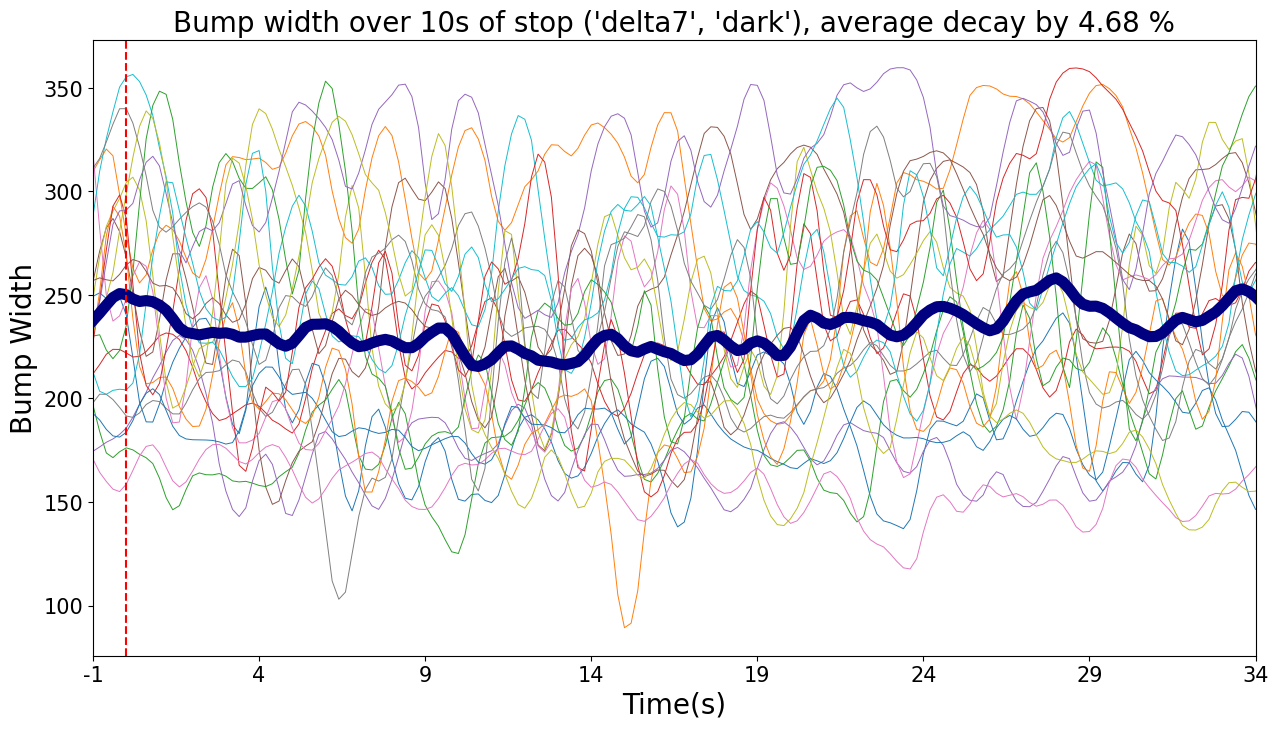

In [128]:
average_decay_Bump_W = round((output_bump_width_pooled.mean(axis=1)[0]-output_bump_width_pooled.mean(axis=1)[49])/output_bump_width_pooled.mean(axis=1)[0]*100,2)
time_array_decay = np.arange(len(output_bump_width_pooled.mean(axis=1)))/5
plt.figure(figsize=(15,8))
for i in range(len(output_bump_width_pooled.columns)):
    plt.plot(time_array_decay,output_bump_width_pooled[i],linewidth = 0.7)
plt.plot(time_array_decay,output_bump_width_pooled.mean(axis=1), linewidth=8, color = 'navy')
plt.xticks(ticks=plt.xticks()[0][0:], labels=np.array(plt.xticks()[0][0:]-active_period_before_len, dtype=np.int64), fontsize=15)
plt.yticks(fontsize=15)
plt.axvline(x= 1, color = 'r',linestyle ='--')
plt.xlim(0,bump_amplitude_stopping_duration)
plt.xlabel('Time(s)', fontsize=20)
plt.ylabel('Bump Width', fontsize=20)
plt.title(f"Bump width over 10s of stop {celltype, trial_condition}, average decay by {average_decay_Bump_W} %",fontsize =20)
plt.show()

In [22]:
if run_vonMises_fitting == 1:
    average_decay_Bump_width_v = round((output_bump_width_vonMises_pooled.mean(axis=1)[0]-output_bump_width_vonMises_pooled.mean(axis=1)[49])/output_bump_width_vonMises_pooled.mean(axis=1)[0]*100,2)
    time_array_decay = np.arange(len(output_bump_width_vonMises_pooled.mean(axis=1)))/5
    plt.figure(figsize=(10,6))
    for i in range(len(output_bump_width_vonMises_pooled.columns)):
        plt.plot(time_array_decay,output_bump_width_vonMises_pooled[i],linewidth = 0.7)
    plt.plot(time_array_decay,output_bump_width_vonMises_pooled.mean(axis=1), linewidth=8, color = 'navy')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlim(0,9.8)
    plt.xlabel('Time(s)', fontsize=20)
    plt.ylabel('Bump Width-von Mises', fontsize=20)
    plt.title(f"Bump Width-von Mises over 10s of stop {celltype, trial_condition}, average decay by {average_decay_Bump_width_v} %",fontsize =20)
    plt.show()

In [23]:
output_df_pooled

FlyTrial          Genotype TrialType  Period_duration   
0    TQfly134-005  delta7>iGluSnFR,      dark          4.08136  \
1    TQfly134-005  delta7>iGluSnFR,      dark          3.24108   
2    TQfly134-005  delta7>iGluSnFR,      dark         10.44348   
3    TQfly134-005  delta7>iGluSnFR,      dark          9.60320   
4    TQfly134-005  delta7>iGluSnFR,      dark          5.28176   
..            ...               ...       ...              ...   
410  TQfly138-003  delta7>iGluSnFR,      dark          4.68636   
411  TQfly138-003  delta7>iGluSnFR,      dark         80.89550   
412  TQfly138-003  delta7>iGluSnFR,      dark          3.34740   
413  TQfly138-003  delta7>iGluSnFR,      dark         11.04642   
414  TQfly138-003  delta7>iGluSnFR,      dark         20.30756   

     PVA_before_stop  PVA_at_restart  PVA_100ms_before_restart   
0        -116.716054     -114.552899               -103.824783  \
1        -176.785138      158.175081                163.509040   
2        -178.087316     -152.297320               -166.469927   
3        -112.286337      -97.539423               -115.397724   
4          77.625260       59.373306                 48.769214   
..               ...             ...                       ...   
410        73.682551     -138.839878               -171.071685   
411      -127.285387     -161.850801               -158.007262   
412      -154.191178      107.111452                 94.936974   
413      -130.066752     -173.456043               -176.808709   
414      -138.662961      142.552501                136.816176   

     PVA_500ms_before_restart  PVA_in_middle  PVA_2s_before_restart  ...   
0                  -95.125297    -104.286390            -106.324051  ...  \
1                  178.677889     174.604003            -170.868646  ...   
2                 -156.976787    -152.124713            -154.432408  ...   
3                 -123.562784     -96.795750            -132.980701  ...   
4                   26.098355     126.472032              83.086145  ...   
..                        ...            ...                    ...  ...   
410                -77.975209     162.973540              71.704303  ...   
411                179.122050    -150.812014             149.798916  ...   
412                156.404612     143.723474             158.903807  ...   
413                170.450082    -127.684390            -147.024420  ...   
414                137.663989    -144.554296             138.624902  ...   

     bump_amplitude_before_stop  bump_amplitude_at_restart   
0                      0.666869                   0.454183  \
1                      0.689237                   0.430453   
2                      0.703971                   0.607125   
3                      1.061061                   0.525052   
4                      0.848677                   0.722250   
..                          ...                        ...   
410                    0.467785                   0.541190   
411                    0.655486                   0.521109   
412                    0.457025                   0.317538   
413                    0.810612                   0.685367   
414                    1.009430                   0.442302   

     bump_amplitude_100ms_before_restart  bump_amplitude_500ms_before_restart   
0                               0.464199                             0.383558  \
1                               0.452120                             0.655254   
2                               0.429590                             0.649210   
3                               0.520936                             0.496171   
4                               0.577392                             0.804814   
..                                   ...                                  ...   
410                             0.266912                             0.207699   
411                             0.432182                             0.416844   
412                             0.37

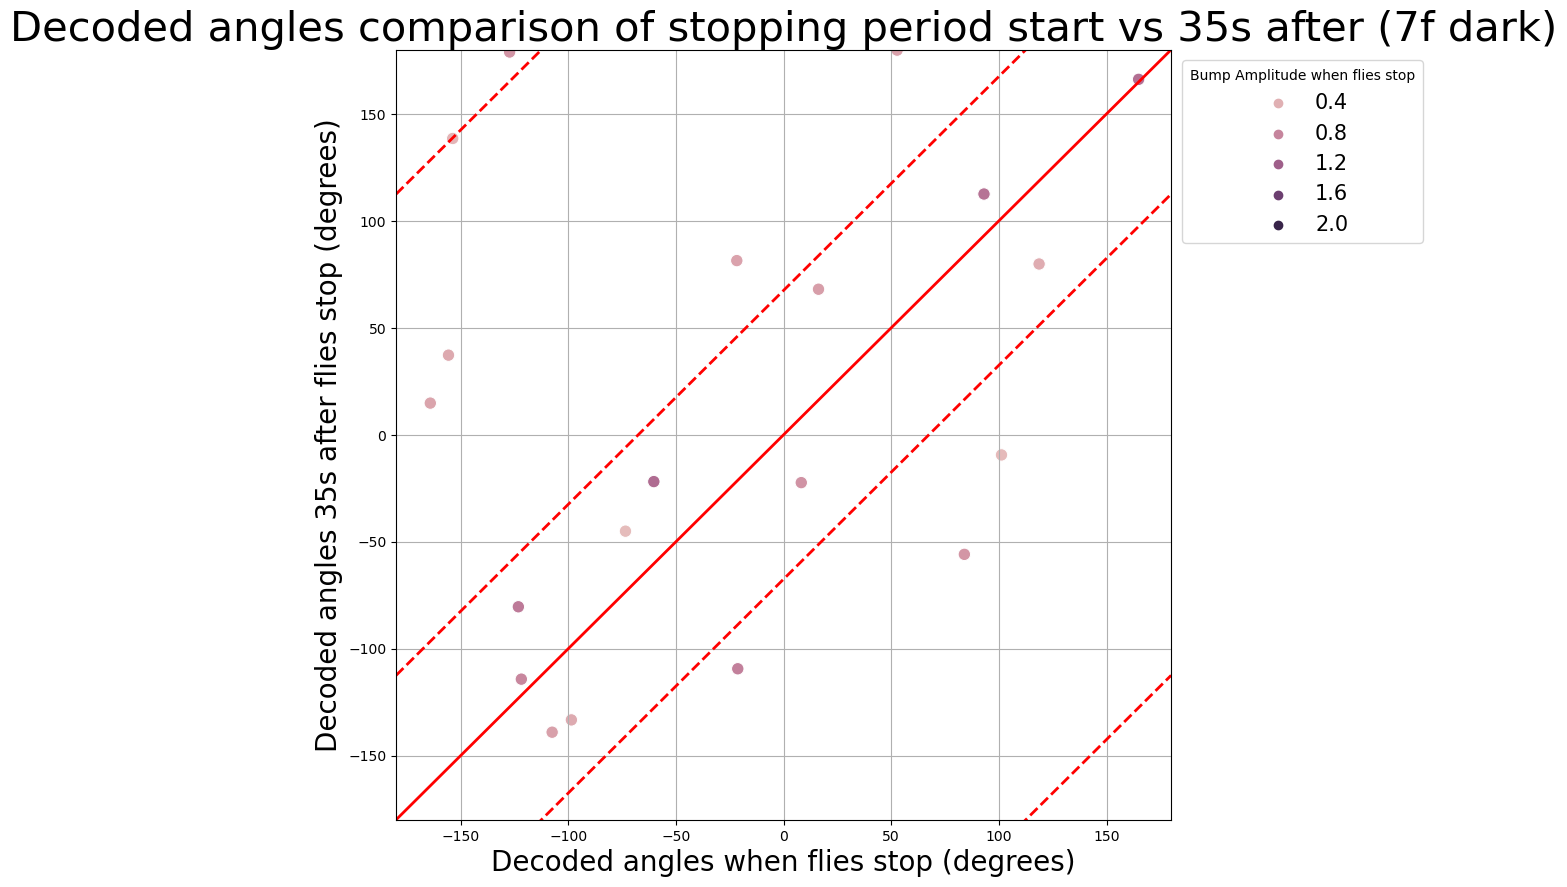

In [24]:
a = plt.figure(figsize= (10,10))
cmap = sns.cubehelix_palette(rot = -.2, as_cmap = True)
snsplot = sns.scatterplot(data = output_df_pooled, x='PVA_before_stop', y='PVA_35s_after_stop', hue = 'bump_amplitude_before_stop', s =80)
snsplot.legend(bbox_to_anchor= (1,1), title = 'Bump Amplitude when flies stop', fontsize = 15)
X_plot = np.linspace(-180, 180, 100)
Y_plot = X_plot
plt.plot(X_plot,Y_plot, color='r', linewidth =2)
plt.plot(X_plot,Y_plot + 67.5, color='r', linestyle ='--', linewidth =2)
plt.plot(X_plot,Y_plot - 67.5, color='r', linestyle ='--', linewidth =2)
plt.plot(X_plot,Y_plot + 292.5, color='r', linestyle ='--', linewidth =2)
plt.plot(X_plot,Y_plot - 292.5, color='r', linestyle ='--', linewidth =2)
plt.ylim(-180, 180)
plt.xlim(-180, 180)
plt.title('Decoded angles comparison of stopping period start vs 35s after (7f dark)', fontsize =30)
plt.ylabel('Decoded angles 35s after flies stop (degrees)',fontsize= 20)
plt.xlabel('Decoded angles when flies stop (degrees)',fontsize= 20)
#plt.setp(snsplot.get_legend().get_texts(), fontsize = 10)
plt.grid()
plt.show()
#a.savefig('E-PG_Bump_Angle_35s_after_dark', format ='svg')

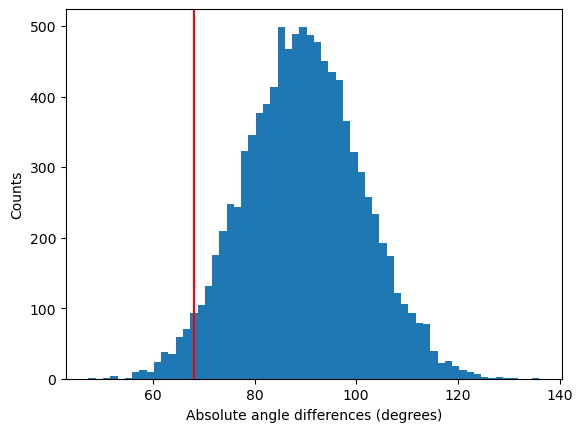

In [25]:
dark_stop_period_start_35s = np.zeros(len(np.argwhere(np.isnan(output_df_pooled['PVA_35s_after_stop'])==0)))
dark_stop_period_end_35s = np.zeros(len(np.argwhere(np.isnan(output_df_pooled['PVA_35s_after_stop'])==0))) 
long_trial_index = np.argwhere(np.isnan(output_df_pooled['PVA_35s_after_stop'])==0)
for i in range(len(dark_stop_period_start_35s )):
    dark_stop_period_start_35s[i] = output_df_pooled['PVA_before_stop'][long_trial_index[i][0]]
    dark_stop_period_end_35s[i] =  output_df_pooled['PVA_35s_after_stop'][long_trial_index[i][0]]
## Pilot code for boot stramping paired angle difference between start and end of the stopping period

#initialize a bootstrap array
bootstrap_mean_angle_differences_10000 = np.zeros(10000)
#size of each sampling 
pair_num = len(dark_stop_period_start_35s)

for i in range(len(bootstrap_mean_angle_differences_10000)):
    random_stop_start_angle = np.random.choice(dark_stop_period_start_35s,size = pair_num)
    random_stop_end_angle = np.random.choice(dark_stop_period_end_35s,size = pair_num)
    angle_difference = calculate_angle_difference_between_two_time_point(random_stop_start_angle,random_stop_end_angle)
    bootstrap_mean_angle_differences_10000[i] = np.mean(np.abs(angle_difference))   

actual_mean_absolute_angle_diff_dark_diff =  calculate_angle_difference_between_two_time_point(dark_stop_period_start_35s ,dark_stop_period_end_35s)
actual_mean_absolute_angle_diff_dark = np.mean(np.abs(actual_mean_absolute_angle_diff_dark_diff))
actual_mean_absolute_angle_diff_dark     
    
plt.hist(bootstrap_mean_angle_differences_10000 ,bins='auto')
plt.axvline(x = actual_mean_absolute_angle_diff_dark, color = 'r')
plt.xlabel('Absolute angle differences (degrees)')
plt.ylabel('Counts')
plt.show()

In [26]:
actual_mean_absolute_angle_diff_dark     

68.09341121173755

In [27]:
np.percentile(bootstrap_mean_angle_differences_10000, 0.0005)

47.52173275678926